In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression

%matplotlib inline

# Import des datasets au format csv

Description datasets :
- actif_financiers (27, 9) : patrimoine moyen par habitant par an de 1995 à 2021 et sa répartition (dépôt banque, assurance vie...)
- foyers_fiscaux (245852, 15) : détails sur le nb de foyers fiscaux, le revenu fiscal moyen, le montant d'impot moyen par ville et par an de 2014 à 2020
- indice_reference_loyers (81, 2) : IRL par trimestre de 2002 à 2022
- loyers (70421, 6) : loyers au m² moyen appartement et maison par ville de 2018 et 2022
- parc_immobilier (46218, 6) : nb logements et nb logements vacants par ville de 2019 à 2021
- taux_endettement (12, 2) : taux_d'endettement des ménages (montant des crédits / revenu brut disponible) par an de 2010 à 2021
- taux_interet (131, 6) : taux d'intérêts par trimestre de 1990 à 2022
- transactions (7217765, 20) : transactions immobilières de 2014 à juin 2022

In [2]:
actif_financiers = pd.read_csv("Data/actifs_financiers.csv")
foyers_fiscaux = pd.read_csv("Data/foyers_fiscaux.csv")
indice_reference_loyers = pd.read_csv("Data/indice_reference_loyers.csv")
loyers = pd.read_csv("Data/loyers.csv")
parc_immobilier = pd.read_csv("Data/parc_immobilier.csv")
taux_endettement = pd.read_csv("Data/taux_endettement.csv")
taux_interet = pd.read_csv("Data/taux_interet.csv")
transactions_sample = pd.read_csv("Data/transactions_sample.csv")

In [3]:
loyers["date"].value_counts()

2018    35441
2022    34980
Name: date, dtype: int64

# Import du dataset transactions.npz

In [4]:
arrays = dict(np.load("Data/transactions.npz"))
data = {k: [s.decode("utf-8") for s in v.tobytes().split(b"\x00")] if v.dtype == np.uint8 else v for k, v in arrays.items()}
transactions = pd.DataFrame.from_dict(data)

In [5]:
transactions

,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,surface_habitable,id_parcelle_cadastre,latitude,longitude,surface_dependances,surface_locaux_industriels,surface_terrains_agricoles,surface_terrains_sols,surface_terrains_nature
0,299378,2014-01-02,157500.0,01,451,VIRIAT,1440,1369 RTE DE STRASBOURG,Maison,False,4,103,01451000ZO0158,46.236407,5.262935,{},{},{},"{24,1569}",{}
1,296650,2014-01-02,112000.0,01,365,SAINT-JEAN-SUR-VEYLE,1290,5174 SAINT JEAN SUR VEYLE,Maison,False,3,78,013650000C0813,46.260087,4.918587,{},{},{220},{540},{}
2,303426,2014-01-02,173020.0,01,202,LAGNIEU,1150,21 GR GRANDE RUE DE BULLIEZ,Maison,False,4,72,012020000F1248,45.899056,5.354210,{},{},{},"{336,191}",{}
3,299064,2014-01-02,197000.0,01,427,TREVOUX,1600,6346 MTE DES LILAS,Appartement,False,4,84,01427000AD0575,45.942301,4.770694,"{0,0}",{},{},{},{}
4,305547,2014-01-03,49023.3,01,27,BALAN,1360,7 LOT AFU DE BARBAREL,Maison,False,5,105,010270000D1790,45.832127,5.097926,{},{},{},{1027},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7217760,11557673,2022-06-30,139000.0,974,16,SAINT PIERRE,97410,11 CHE EMMANUEL BAILLIF,Appartement,False,2,50,97416000IE0152,-21.302350,55.460860,{0},{},{},{},{}
7217761,11557335,2022-06-30,278000.0,974,13,SAINT-LEU,97424,11 RUE GALABE,Appartement,False,3,62,97413000DB0349,-21.215177,55.296735,{0},{},{},{},{}
7217762,11557295,2022-06-30,29340.0,974,15,SAINT-PAUL,97422,70 RUE PERIANMODELY,Maison,False,4,105,97415000ET1566,-21.083460,55.264731,{},{},{},{489},{}
7217763,11557641,2022-06-30,140000.0,974,16,SAINT PIERRE,97410,347 CHE DU CIMETIERE,Maison,False,3,52,97416000EY1407,-21.324139,55.539725,{0},{},{},"{189,183}",{}


D:\TEMP\ipykernel_8044\2781709291.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(transactions.corr(), annot=True, cmap='Reds')


<AxesSubplot: >

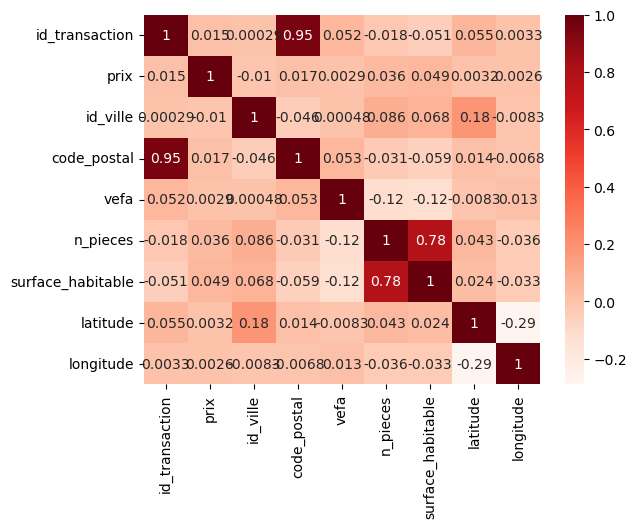

In [8]:
sns.heatmap(transactions.corr(), annot=True, cmap='Reds')

# 1ère modélisation : test sur l'ensemble des données de 2021 à juin 2022

### Sélection des transactions de 2021 à juin 2022

In [12]:
transactions_2021_2022 = transactions[(transactions['date_transaction'] >= '2021-01-01') & (transactions['date_transaction'] <= '2022-06-30')]

### Pré selection des variables

In [13]:
transactions_2021_2022=transactions_2021_2022[['date_transaction','prix','departement','id_ville','code_postal','latitude', 'longitude',
                               'type_batiment','vefa','n_pieces','surface_habitable']].reset_index(drop=True)

In [14]:
# Création des variables temporelles
transactions_2021_2022["annee"] = transactions_2021_2022["date_transaction"].dt.year
transactions_2021_2022["mois"] = transactions_2021_2022["date_transaction"].dt.month
transactions_2021_2022["jour"] = transactions_2021_2022["date_transaction"].dt.weekday

In [47]:
# Suppression de la date
transactions_2021_2022 = transactions_2021_2022.drop("date_transaction", axis=1)

In [48]:
df1 = transactions_2021_2022

In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341581 entries, 0 to 1341580
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   prix               1341581 non-null  float64
 1   departement        1341581 non-null  object 
 2   id_ville           1341581 non-null  int32  
 3   code_postal        1341581 non-null  int32  
 4   latitude           1341581 non-null  float64
 5   longitude          1341581 non-null  float64
 6   type_batiment      1341581 non-null  object 
 7   vefa               1341581 non-null  bool   
 8   n_pieces           1341581 non-null  int32  
 9   surface_habitable  1341581 non-null  int32  
 10  annee              1341581 non-null  int64  
 11  mois               1341581 non-null  int64  
 12  jour               1341581 non-null  int64  
dtypes: bool(1), float64(3), int32(4), int64(3), object(2)
memory usage: 103.6+ MB


### Transformation des variables

In [50]:
df1 = df1.replace({"Appartement":0, "Maison":1})
df1["vefa"] = df1["vefa"].astype(int)
df1["departement"] = df1["departement"].astype(int)

In [51]:
df1

,prix,departement,id_ville,code_postal,latitude,longitude,type_batiment,vefa,n_pieces,surface_habitable,annee,mois,jour
0,499000.0,1,173,1170,46.338213,6.068882,1,0,4,180,2021,1,0
1,297000.0,1,319,1990,46.086428,4.949720,1,0,5,105,2021,1,0
2,204332.0,1,65,1310,46.201002,5.157733,1,0,4,88,2021,1,0
3,226700.0,1,301,1310,46.244110,5.108810,1,0,3,96,2021,1,0
4,165000.0,1,53,1000,46.198721,5.219423,0,0,3,67,2021,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341576,139000.0,974,16,97410,-21.302350,55.460860,0,0,2,50,2022,6,3
1341577,278000.0,974,13,97424,-21.215177,55.296735,0,0,3,62,2022,6,3
1341578,29340.0,974,15,97422,-21.083460,55.264731,1,0,4,105,2022,6,3
1341579,140000.0,974,16,97410,-21.324139,55.539725,1,0,3,52,2022,6,3


In [52]:
features = df.drop("prix", axis=1)
target = df["prix"]

In [53]:
nb_rows_train = int(round(len(df)*0.8,0))

X_train = features[:nb_rows_train]
y_train = target[:nb_rows_train]
X_test = features[nb_rows_train:]
y_test = target[nb_rows_train:]

In [54]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.11177364378259969

In [55]:
lr.score(X_test,y_test)

-126.11614606501678

# 2ème modélisation : test sur des données récentes d'une ville/quartier

In [148]:
df2 = transactions_2021_2022

In [149]:
df2 = df2[(df2["code_postal"]==75003) & (df2["annee"]==2022) & (df2["mois"] >= 4)]

In [150]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 967842 to 977073
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prix               188 non-null    float64
 1   departement        188 non-null    object 
 2   id_ville           188 non-null    int32  
 3   code_postal        188 non-null    int32  
 4   latitude           188 non-null    float64
 5   longitude          188 non-null    float64
 6   type_batiment      188 non-null    object 
 7   vefa               188 non-null    bool   
 8   n_pieces           188 non-null    int32  
 9   surface_habitable  188 non-null    int32  
 10  annee              188 non-null    int64  
 11  mois               188 non-null    int64  
 12  jour               188 non-null    int64  
dtypes: bool(1), float64(3), int32(4), int64(3), object(2)
memory usage: 16.3+ KB


In [151]:
df2

,prix,departement,id_ville,code_postal,latitude,longitude,type_batiment,vefa,n_pieces,surface_habitable,annee,mois,jour
967842,729550.0,75,103,75003,48.862612,2.356146,Appartement,False,2,50,2022,4,4
967866,1238000.0,75,103,75003,48.865675,2.357697,Appartement,False,4,89,2022,4,4
967911,1770000.0,75,103,75003,48.866272,2.358032,Appartement,False,5,103,2022,4,4
967913,700000.0,75,103,75003,48.862779,2.363898,Appartement,False,2,41,2022,4,4
968001,350000.0,75,103,75003,48.861959,2.351511,Appartement,False,1,28,2022,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
976821,650000.0,75,103,75003,48.865074,2.357316,Appartement,False,3,56,2022,6,3
976849,2146036.0,75,103,75003,48.857877,2.361955,Appartement,False,5,144,2022,6,3
976895,430410.0,75,103,75003,48.865797,2.361798,Appartement,False,2,34,2022,6,3
977001,495011.0,75,103,75003,48.861011,2.356144,Appartement,False,2,37,2022,6,3


D:\TEMP\ipykernel_8044\2610453807.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df2.corr(), annot=True, cmap='Reds')


<AxesSubplot: >

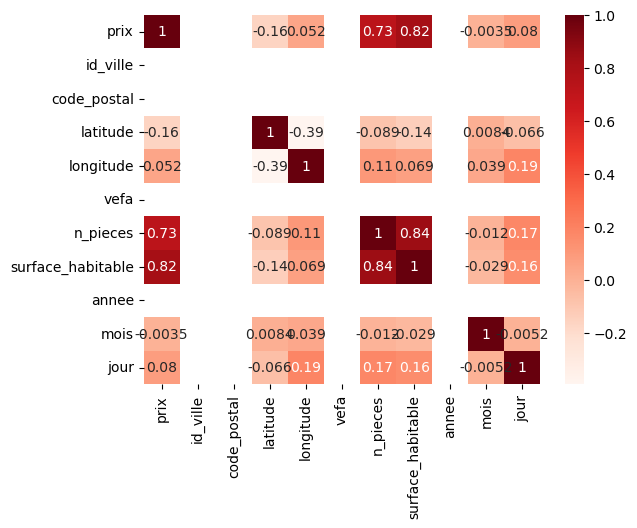

In [152]:
sns.heatmap(df2.corr(), annot=True, cmap='Reds')

In [153]:
df2 = df2[["prix", "n_pieces", "surface_habitable"]]

In [154]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 967842 to 977073
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prix               188 non-null    float64
 1   n_pieces           188 non-null    int32  
 2   surface_habitable  188 non-null    int32  
dtypes: float64(1), int32(2)
memory usage: 4.4 KB


In [155]:
df2

,prix,n_pieces,surface_habitable
967842,729550.0,2,50
967866,1238000.0,4,89
967911,1770000.0,5,103
967913,700000.0,2,41
968001,350000.0,1,28
...,...,...,...
976821,650000.0,3,56
976849,2146036.0,5,144
976895,430410.0,2,34
977001,495011.0,2,37


In [156]:
scaler = MinMaxScaler()

In [157]:
df2_scaled = pd.DataFrame(scaler.fit_transform(df2))
df2_scaled = df2_scaled.rename(columns=dict(zip(df2_scaled.columns, df2.columns)))

In [158]:
df2_scaled

,prix,n_pieces,surface_habitable
0,0.303979,0.111111,0.256098
1,0.515833,0.333333,0.493902
2,0.737500,0.444444,0.579268
3,0.291666,0.111111,0.201220
4,0.145833,0.000000,0.121951
...,...,...,...
183,0.270833,0.222222,0.292683
184,0.894182,0.444444,0.829268
185,0.179337,0.111111,0.158537
186,0.206254,0.111111,0.176829


### Séparation du dataset en données d'entrainement et de test

In [159]:
features = df2_scaled.drop("prix", axis=1)
target = df2_scaled["prix"]

In [160]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

In [161]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.6187424895807412

In [162]:
y_pred = lr.predict(X_test)

In [163]:
print('score test :', lr.score(X_test, y_test))
print('mse test :', mean_squared_error(y_pred, y_test))

score test : 0.8269850850833408
mse test : 0.008045683884107946


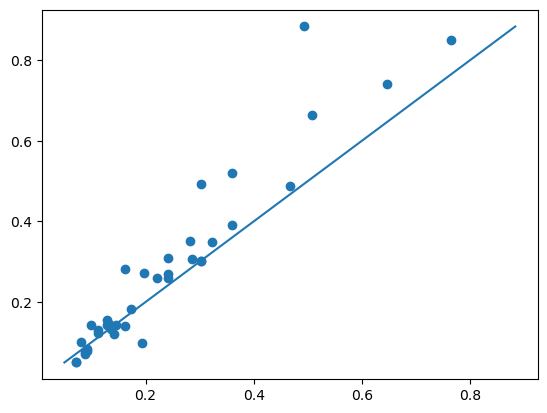

In [164]:
plt.scatter(y_pred, y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()));

### Validation croisée

In [165]:
model = LinearRegression()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, features, target, cv=kfold, scoring='r2')

In [166]:
print('Scores :', scores)
print('R² : {:.2f} (+/- {:.2f})'.format(scores.mean(), scores.std()*2))

Scores : [0.76554552 0.81677934 0.63195999 0.20656703 0.70770601]
R² : 0.63 (+/- 0.44)
